# sarima Forecasting

## Importing the libraries

In [105]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Importing the dataset

In [106]:
# pyspark_df = spark.table("sd_bdc_demo.sarima_time_series_forecasting.2_am_workday_historic_time_series_updated_data")
# pyspark_df.display()
# df = pyspark_df.toPandas()

In [107]:
df = pd.read_csv("2_am_workday_historic_time_series_updated_data/2_am_workday_historic_time_series_updated_data.csv")


In [108]:
print(df.head())

   Employee_ID year_month  Annual_load_cost_per_month
0           57    2000-07                      9329.0
1           57    2000-08                      9329.0
2           57    2000-09                      9329.0
3           57    2000-10                      9329.0
4           57    2000-11                      9329.0


In [109]:
print(df.columns)

Index(['Employee_ID', 'year_month', 'Annual_load_cost_per_month'], dtype='object')


In [110]:
print(df.dtypes)

Employee_ID                     int64
year_month                     object
Annual_load_cost_per_month    float64
dtype: object


In [111]:
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')

In [112]:
print(df.dtypes)

Employee_ID                            int64
year_month                    datetime64[ns]
Annual_load_cost_per_month           float64
dtype: object


In [113]:
print(df.shape)

(30000, 3)


In [114]:
print(df['year_month'])

0       2000-07-01
1       2000-08-01
2       2000-09-01
3       2000-10-01
4       2000-11-01
           ...    
29995   2025-02-01
29996   2025-03-01
29997   2025-04-01
29998   2025-05-01
29999   2025-06-01
Name: year_month, Length: 30000, dtype: datetime64[ns]


## 100 Different Data Frame For Individual User

In [115]:
unique_employees = df['Employee_ID'].unique()
print(unique_employees)

[ 57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156]


In [116]:
employee_dfs = {}

# Step 4: Loop through each employee ID
for emp_id in unique_employees:
    # Step 5: Filter data for just this employee
    emp_df = df[df['Employee_ID'] == emp_id]

    # Step 6: Save it into the dictionary
    employee_dfs[emp_id] = emp_df

In [117]:
individual_emp = employee_dfs[58]
print(individual_emp)

     Employee_ID year_month  Annual_load_cost_per_month
300           58 2000-07-01                     5427.00
301           58 2000-08-01                     5427.00
302           58 2000-09-01                     5427.00
303           58 2000-10-01                     5427.00
304           58 2000-11-01                     5427.00
..           ...        ...                         ...
595           58 2025-02-01                     7743.84
596           58 2025-03-01                     7743.84
597           58 2025-04-01                     7743.84
598           58 2025-05-01                     7743.84
599           58 2025-06-01                     7743.84

[300 rows x 3 columns]


In [118]:
print(individual_emp.shape)

(300, 3)


## Forecasting with SARIMAX But without exogenous variable

In [119]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import pandas as pd

def forecast_sarima(emp_df, steps=12):
    emp_df = emp_df.copy()
    emp_df['year_month'] = pd.to_datetime(emp_df['year_month'])
    emp_df = emp_df.sort_values('year_month').set_index('year_month')
    y = emp_df['Annual_load_cost_per_month']

    train = y.iloc[:-steps]
    test = y.iloc[-steps:]

    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), 
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    forecast = model_fit.forecast(steps=steps)

    # Compute residuals on training data
    residuals = model_fit.resid
    residuals_df = residuals.reset_index()
    residuals_df.columns = ['year_month', 'residual_value']

    # Metrics
    aic = model_fit.aic
    mape = mean_absolute_percentage_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    return forecast, {
        'AIC': aic,
        'MAPE': mape,
        'RMSE': rmse,
        'ARIMA_order': model_fit.model_orders,
        'residuals': residuals_df
    }

In [120]:
employee_forecasts = {}
employee_metrics = {}
all_residuals = []

for emp_id, emp_df in employee_dfs.items():
    try:
        forecast, metrics = forecast_sarima(emp_df, steps=12)
        employee_forecasts[emp_id] = forecast
        employee_metrics[emp_id] = metrics

        # Add residuals to the master list
        residual_df = metrics['residuals'].copy()
        residual_df['Employee_ID'] = emp_id
        all_residuals.append(residual_df)

    except Exception as e:
        print(f"Failed for Employee {emp_id}: {e}")


c:\Users\LakshmanNavaneethakr\Downloads\lakshmansierra-git\poc_time_series_analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LakshmanNavaneethakr\Downloads\lakshmansierra-git\poc_time_series_analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LakshmanNavaneethakr\Downloads\lakshmansierra-git\poc_time_series_analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\LakshmanNavaneethakr\Downloads\lakshmansierra-git\poc_time_series_analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information w

In [121]:
print(type(employee_forecasts))

<class 'dict'>


In [122]:
print(employee_forecasts.items())

dict_items([(np.int64(57), 2024-07-01    13618.173205
2024-08-01    13618.167031
2024-09-01    13637.419869
2024-10-01    13637.419876
2024-11-01    13644.197440
2024-12-01    13644.197443
2025-01-01    13644.197470
2025-02-01    13971.617144
2025-03-01    13974.534755
2025-04-01    13974.534731
2025-05-01    13974.534729
2025-06-01    13974.532787
Freq: MS, Name: predicted_mean, dtype: float64), (np.int64(58), 2024-07-01    7746.636681
2024-08-01    7746.636671
2024-09-01    7746.636670
2024-10-01    7746.636670
2024-11-01    7746.636671
2024-12-01    7747.824454
2025-01-01    7747.824454
2025-02-01    7747.824454
2025-03-01    7747.824454
2025-04-01    7747.824455
2025-05-01    7899.520293
2025-06-01    7899.520289
Freq: MS, Name: predicted_mean, dtype: float64), (np.int64(59), 2024-07-01    13347.032965
2024-08-01    13341.635339
2024-09-01    13345.855897
2024-10-01    13342.555722
2024-11-01    13858.139114
2024-12-01    13856.121345
2025-01-01    13857.699096
2025-02-01    16632.

In [123]:
print(employee_forecasts[156])

2024-07-01    34356.970000
2024-08-01    34356.970000
2024-09-01    34356.970000
2024-10-01    34357.012750
2024-11-01    34357.012750
2024-12-01    34357.012750
2025-01-01    34357.012750
2025-02-01    34357.012750
2025-03-01    39685.789903
2025-04-01    39685.789903
2025-05-01    39685.789903
2025-06-01    39685.789903
Freq: MS, Name: predicted_mean, dtype: float64


### Saving all employee residual data in a table

## 🔴 NOTE
- `residual value` = `Actual Annual_load_cost_per_month` - `predicted Annual_load_cost_per_month` <br> 
of each train data of `288` historic data
- `residual value should be as close to zero as possible`

In [124]:
# Combine all residuals into one DataFrame
residuals_combined_df = pd.concat(all_residuals, ignore_index=True)

# Optional: sort and format
residuals_combined_df = residuals_combined_df[['Employee_ID', 'year_month', 'residual_value']]
residuals_combined_df['year_month'] = residuals_combined_df['year_month'].dt.strftime('%Y-%m')


In [125]:
# Create the folder if it doesn't exist
os.makedirs("3_3_am_workday_sarima_residuals_data", exist_ok=True)

# Save the Excel file inside the folder
residuals_combined_df.to_csv("3_3_am_workday_sarima_residuals_data/3_3_am_workday_sarima_residuals_data.csv", index=False)

In [126]:
# spark_df = spark.createDataFrame(residuals_combined_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.sarima_time_series_forecasting.3_3_am_workday_sarima_residuals_data")

### Saving all employee ACF data in a table

## 🔴 NOTE
- `Lag` = How far back you are looking in time (e.g., 1 month ago, 2 months ago, etc.)
- `Autocorrelation` = How strongly the series is correlated with its own past values
- `ACF should be as close to zero as possible (except at lag 0)`

## 📌 Guidelines to choose `nlags`
| Scenario                       | Suggested `nlags`                   |
| ------------------------------ | ----------------------------------- |
| Short-term trend check         | 10–20                               |
| Monthly data with seasonality  | ≥ 12 (check for 12-month patterns)  |
| Quarterly data                 | ≥ 4 or 8                            |
| Long series (e.g., 300 points) | Up to 40–50 or more                 |
| Residual analysis              | 12–20 (slightly > forecast horizon) |

## ✅ Interpretation-1
| Lag (k) | Meaning                                                           | Expected ACF Value                              |
| ------- | ----------------------------------------------------------------- | ----------------------------------------------- |
| 0       | Correlation of series with itself                                 | Always 1                                        |
| 1       | Correlation with value 1 step before (e.g., 1 month ago)          | High if trend/seasonality exists, else low      |
| 2       | Correlation with value 2 steps before                             | Usually lower than lag 1 unless there's pattern |
| ...     | ...                                                               | Decreasing or oscillating depending on data     |
| 12      | Monthly seasonality — high ACF if pattern repeats every 12 months | High if strong seasonality                      |
| ≥ 13    | Less meaningful unless long-term memory or seasonality persists   | Usually low                                     |

## ✅ Interpretation-2
| Lag | Expected ACF                                            |
| --- | ------------------------------------------------------- |
| 0   | 1 (always)                                              |
| ≥1  | **Close to 0** — means model has captured all structure |



In [127]:
residuals_df = pd.concat(all_residuals).reset_index(drop=True)

In [128]:
from statsmodels.tsa.stattools import acf

acf_rows = []

# Loop through each employee's residuals
for emp_id in residuals_df['Employee_ID'].unique():
    emp_resid = residuals_df[residuals_df['Employee_ID'] == emp_id]
    emp_resid_sorted = emp_resid.sort_values('year_month')
    acf_values = acf(emp_resid_sorted['residual_value'], nlags=20)

    for lag, val in enumerate(acf_values):
        acf_rows.append({
            'Employee_ID': emp_id,
            'Lag': lag,
            'ACF_Value': round(val, 4)
        })

acf_df = pd.DataFrame(acf_rows)


In [129]:
# Create the folder if it doesn't exist
os.makedirs("3_4_am_workday_sarima_acf_data", exist_ok=True)

# Save the Excel file inside the folder
acf_df.to_csv("3_4_am_workday_sarima_acf_data/3_4_am_workday_sarima_acf_data.csv", index=False)

In [130]:
# spark_df = spark.createDataFrame(acf_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.sarima_time_series_forecasting.3_4_am_workday_sarima_acf_data")

### Metrics for each employee

In [131]:
print(f"Employee 100 Metrics: {employee_metrics[100]}")


Employee 100 Metrics: {'AIC': np.float64(3720.015745141064), 'MAPE': 0.012386781208897845, 'RMSE': np.float64(205.59545179055092), 'ARIMA_order': {'trend': 0, 'exog': 0, 'ar': 1, 'ma': 1, 'seasonal_ar': 12, 'seasonal_ma': 12, 'reduced_ar': 13, 'reduced_ma': 13, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}, 'residuals':     year_month  residual_value
0   2000-07-01    1.024400e+04
1   2000-08-01    6.894454e+00
2   2000-09-01   -5.961351e-03
3   2000-10-01    5.154534e-06
4   2000-11-01   -4.456524e-09
..         ...             ...
283 2024-02-01   -2.632078e-09
284 2024-03-01   -6.366463e-11
285 2024-04-01    5.497714e-08
286 2024-05-01   -5.459865e-05
287 2024-06-01    5.422508e-02

[288 rows x 2 columns]}


### Saving all employee metrics in a table

In [132]:
rows = []

for emp_id, metrics in employee_metrics.items():
    ar = metrics['ARIMA_order'].get('ar', '?')
    d = 1  # assumed differencing, adjust if dynamic
    ma = metrics['ARIMA_order'].get('ma', '?')

    seasonal_ar = metrics['ARIMA_order'].get('seasonal_ar', '?')
    seasonal_d = 1  # assumed seasonal differencing
    seasonal_ma = metrics['ARIMA_order'].get('seasonal_ma', '?')
    s = 12  # assumed seasonality
    
    rows.append({
        'Employee_ID': emp_id,
        'AIC_unitless': round(float(metrics['AIC']), 2),
        'MAPE_%': round(float(metrics['MAPE']) * 100, 2),
        'RMSE_$': round(float(metrics['RMSE']), 2),
        'ARIMA_order': f"({ar},{d},{ma})",
        'Seasonal_order': f"({seasonal_ar},{seasonal_d},{seasonal_ma},{s})"
    })

metrics_df_clean = pd.DataFrame(rows)


In [133]:
# Create the folder if it doesn't exist
os.makedirs("3_1_am_workday_sarima_metrics_data", exist_ok=True)

# Save the Excel file inside the folder
metrics_df_clean.to_csv("3_1_am_workday_sarima_metrics_data/3_1_am_workday_sarima_metrics_data.csv", index=False)

In [134]:
# spark_df = spark.createDataFrame(metrics_df_clean)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.sarima_time_series_forecasting.3_1_am_workday_sarima_metrics_data")

## Plot Prediction of Single Employe

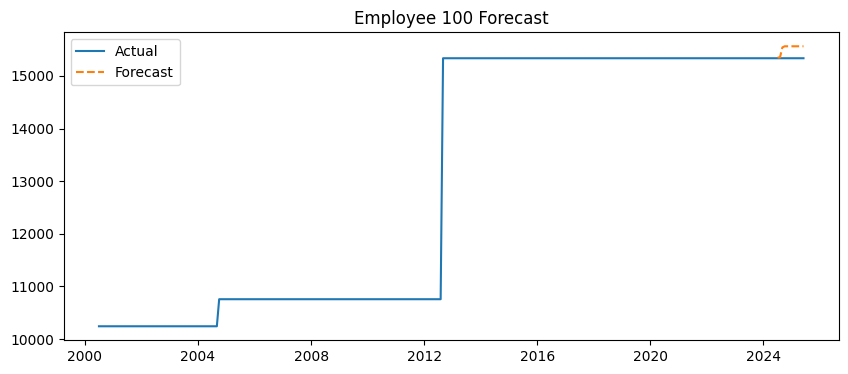

In [135]:
import matplotlib.pyplot as plt

emp_id = 100
emp_df = employee_dfs[emp_id].copy()
emp_df['year_month'] = pd.to_datetime(emp_df['year_month'])
emp_df.set_index('year_month', inplace=True)

forecast = employee_forecasts[emp_id]

plt.figure(figsize=(10, 4))
plt.plot(emp_df['Annual_load_cost_per_month'], label='Actual')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title(f'Employee {emp_id} Forecast')
plt.legend()
plt.show()

## Saving the Predicted Data

In [136]:
all_forecasts = []

for emp_id, forecast_series in employee_forecasts.items():
    for date, cost in forecast_series.items():
        all_forecasts.append({
            'Employee_ID': emp_id,
            'Upcoming_year_month': date,
            'Forecasted_cost_per_month': round(cost, 0)
        })

forecast_df = pd.DataFrame(all_forecasts)

# Step 4: Sort and reset index (optional but clean)
forecast_df = forecast_df.sort_values(['Employee_ID', 'Upcoming_year_month']).reset_index(drop=True)


In [137]:
print(forecast_df.head())

   Employee_ID Upcoming_year_month  Forecasted_cost_per_month
0           57          2024-07-01                    13618.0
1           57          2024-08-01                    13618.0
2           57          2024-09-01                    13637.0
3           57          2024-10-01                    13637.0
4           57          2024-11-01                    13644.0


In [138]:
forecast_df['Upcoming_year_month'] = pd.to_datetime(forecast_df['Upcoming_year_month']).dt.strftime('%Y-%m')

## Export Updated Excel

In [139]:
# Create the folder if it doesn't exist
os.makedirs("3_2_am_workday_sarima_forecasted_data", exist_ok=True)

# Save the Excel file inside the folder
forecast_df.to_csv("3_2_am_workday_sarima_forecasted_data/3_2_am_workday_sarima_forecasted_data.csv", index=False)

In [140]:
# spark_df = spark.createDataFrame(forecast_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.sarima_time_series_forecasting.3_2_am_workday_sarima_forecasted_data")